# Object Detection - Part 2 Bounding Boxes
by John Robinson 01/18/2023 [Follow @johnrobinsn on Twitter](https://twitter.com/johnrobinsn)

<img src="https://www.storminthecastle.com/img/02_bounding_box_files/computervision2_256.jpeg"><br/>


[<img src="https://www.storminthecastle.com/img/github.svg">](https://github.com/johnrobinsn/ObjectDetectionNotebooks/blob/main/nbs/02_bounding_box.ipynb) [<img src="https://www.storminthecastle.com/img/colab.svg">](https://colab.research.google.com/github/johnrobinsn/ObjectDetectionNotebooks/blob/main/nbs/02_bounding_box.ipynb)

This is **Part 2** of my series, "Object Detection from Scratch", which is focused on building an intuition for how single-pass oject detectors such as YOLO and SSD work. [Go to Part 1](https://www.storminthecastle.com/posts/01_classification/)  

Object detection considers the problem of building a model that can take an image and detect multiple objects within that image; predicting not only the object classes but also the bounding boxes of those objects within the image.  Single-pass detectors such as YOLO and SSD have solved this problem end-to-end, performing the object detection task in a single forward pass of the model.  If what I'm describing is not clear, here is a fun video of [YOLO in action](https://www.youtube.com/watch?v=MPU2HistivI).

In the previous article, we selected a suitable dataset for learning about object detection and started with the simpler problem of building an object classification model that identifies the largest object within an image.

In this article, we'll climb one more rung up the ladder and build a model that can learn to predict a bounding box for the largest object in an image.  In this series, I make heavy use of the [FastAI](https://github.com/fastai/fastai)(FAI) library.

## Code From the Last Time
We can get started by copy-and-pasting in some of the code that we covered from the [Part 1 notebook.](https://www.storminthecastle.com/posts/01_classification/)

In [1]:
from fastai.vision.all import *

import matplotlib.colors as mcolors
import matplotlib.cm as cmx
from matplotlib import patches, patheffects

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SIZE=224

# display an image in such a way that we can layer on some additional annotations
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    show_image(im,ax) # We use this FastAI method to make life a little easier
    ax.set_xticks(np.linspace(0, SIZE, 8))
    ax.set_yticks(np.linspace(0, SIZE, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

# draw an outline around the shape; used to add contrast to the text so we can read it easily
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

# draw text in the specified location along with an outline so that there is some contrast between the text and the image
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

# generate a list of different colors for rendering our bounding boxes
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

# Grab our dataset
path = untar_data(URLs.PASCAL_2007)
imgs,lbl_bbox = get_annotations(path/'train.json')

# utility function that takes a bounding box in the form of x1,y1,x2,y2 and returns it's area (w*h)
def area(b): return (b[2]-b[0])*(b[3]-b[1])
# zip the bounding boxes together with the object class; sort it descending order by the size of the bounding; return the first one (largest one)
def get_largest(boxes):
    return sorted(L(zip(*boxes)),key=lambda b: -area(b[0]))[0]
    
# list comprehension to go through all of the training data and extract the largest objects
lrg_bbox = [get_largest(boxes) for boxes in lbl_bbox]

/home/jr/anaconda3/envs/fastaip2_3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


This brings us back to the point where we have derived a "largest object dataset" which for a given image contains the largest object in the image along with it's bounding box.  Let's look at a sample to refresh our memory.

In [2]:
# look at a sample from our dictionary
imgs[1],lrg_bbox[1]

('000017.jpg', ([89, 77, 403, 336], 'horse'))

## Scale Our Bounding Boxes
In this notebook, we are going to look at bounding boxes in more depth.  Since our bounding boxes are defined in terms of image coordinates and we're scaling the images down to 224x224, we also need to scale the bounding boxes so they  match up.  For now let's do this in the dataset itself.

In [3]:
# Given the image file name and bounding box will scale the bounding box to 224x224
def squish_bbox(img_file,labeled_bbox):
    bbox,label = labeled_bbox
    p = path/f'train/{img_file}'
    img = Image.open(p)
    h,w = img.shape
    yscale,xscale = h/SIZE,w/SIZE
    scaled_bbox = (bbox[0]//xscale,bbox[1]//yscale,bbox[2]//xscale,bbox[3]//yscale)
    return [scaled_bbox,label]

Try out our squish_bbox function.

In [4]:
lrg_bbox[1] # sample

([89, 77, 403, 336], 'horse')

In [5]:
# scale the bounding box of the sample relative the image scaling
squish_bbox(imgs[1],lrg_bbox[1])

[(41.0, 47.0, 188.0, 206.0), 'horse']

Let's use our squish_bbox function to scale all of the bounding boxes in our 'largest' dataset using a list comprehension.

In [6]:
lrg_bbox_scaled = [squish_bbox(img_file,labeled_bbox) for img_file,labeled_bbox in zip(imgs,lrg_bbox)]

Make a dictionary so that we can easily look up the dependent variables (scaled bounding box and label) given the independent variable (image file name)

In [7]:
img2lrgbboxscaled = dict(zip(imgs,lrg_bbox_scaled))

In [8]:
# look at a sample from our dictionary
k = L(img2lrgbboxscaled)[1]; k,img2lrgbboxscaled[k]

('000017.jpg', [(41.0, 47.0, 188.0, 206.0), 'horse'])

## Visualize Our Bounding Box
For now we're ignoring the class labels and just working with the bounding box for the largest object.

In [9]:
# Draw image with bounding box only
def show_lrg_item(im, lbl_bbox, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax = show_img(im, ax=ax)
    b = lbl_bbox[0]
    b = (*b[:2],b[2]-b[0]+1,b[3]-b[1]+1)
    draw_rect(ax, b, color=colr_list[0])

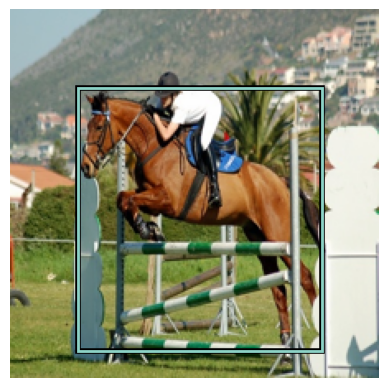

In [10]:
# Look at a sample from our dictionary

img_file = L(img2lrgbboxscaled)[1]
img_bbox_scaled = img2lrgbboxscaled[k]

img_scaled = Image.open(path/f'train/{img_file}').resize((SIZE,SIZE))

show_lrg_item(img_scaled,img_bbox_scaled)

## Training a Bounding Box Prediction Model
We want to train a model that given an image can predict the bounding box rectangle for the largest object in the image.

How might we do this? At this point, I think it might be useful to step back and understand a little more about models and their output activations.

### Transfer Learning and Classification

Let's take another look at the classification model that we built the last time.

In [11]:
# Define the getter that will obtain the input image and the class label associated with the image.
getters = [lambda o: path/'train'/o, lambda o: img2lrgbboxscaled[o][1]]

item_tfms = [Resize(SIZE, method='squish'),]
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 getters=getters,
                 item_tfms=item_tfms)
dls = dblock.dataloaders(imgs, bs = 128)


Let's look at the object classes in our dataset.

In [12]:
# 20 different classes of objects
dls.vocab

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [13]:
# Rebuild our classification model for our twenty different class labels
learn = vision_learner(dls,resnet34)

/home/jr/anaconda3/envs/fastaip2_3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jr/anaconda3/envs/fastaip2_3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FAI's vision_learner API does quite a bit under the hood.  First it constructs a model using the requested [resnet34](https://roboflow.com/model/resnet-34#:~:text=What%20is%20Resnet34%3F,images%20across%20200%20different%20classes.) architecture, initializing the parameters of the model with a downloaded set of pretrained weights.  These pretrained weights are used to do something called transfer learning.  The pretrained weights were obtained by training the resnet34 model to classify images from the imagenet dataset. Imagenet is a large dataset which contains over 100k images with 200 different object classes.  Even though these weights were obtained by training on a completely different dataset, the earlier layers of the model are now effective feature detectors for things like edges, corners, gradients, etc. that are common to almost any image.  Starting off with these weights, our model will be much more efficient and stable when trained than it would be if we started off using random weights.

However since we have different class labels in our dataset, the latter layers of this model aren't that useful.  The vision_learner API will adapt the model to our dataset by cutting the model into two parts.  The first part of our model (with the pretrained weights) will be retained and can be referred to as the backbone of our network.  The latter part of the model, the head, will be discarded and replaced with a dynamically created sequence of linear layers that have twenty output activations to match the number of classes that we want to predict.  The new head will be randomly initialzed and will be trained to map from the backbone features to our desired model output.

We can access the model and show it's structure via the model property.

In [14]:
# Commented out for brevity
# Uncomment the following line to see all of the model layers
#learn.model

The model will have two child nodes, the first child is the network backbone and the second child is the head of the network.

In [15]:
# Commented out for brevity
# Uncomment the following line to see just the backbone layers
#backbone = learn.model[0]; backbone

In [16]:
head = learn.model[1]
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=20, bias=False)
)

For now the most interesting thing to look at is the last layer of the head. As you can see above, the out_features of this layer gives us one output activation for every one of our object classes. When we train this model using our dataset and the CrossEntropy loss function, our model will learn to drive the twenty activations to output the log probability for each one of our twenty classes.

The bounding box problem is of course different than the classification problem, a bounding box consists of four different numbers. The first two representing the upper-left coordinates of the rectangle and the other two representing the lower-right coordinates of the rectangle.  So we need a network that can predict four continuous numbers. If you are trying to predict continuous numbers then you need to use regression.  We will still use the same resnet34 backbone but our head will just need to output four values.  

Something important to mention is that the model architecture itself isn't really task specific. The output activations don't have any semantics by themselves, we just need to have the right number of them.  In the case of the classification problem, we needed twenty activations and in the case of the bounding box problem we need just four activations.  It is really the target data and the loss function that drives the model and its output activations towards the desired behavior.  Let's switch back to building our bounding box model.

### Bounding Box Model

Define a getter for training our model that given an image file name will return the full path to the image file and a tensor containing the four bounding box coordinates of the largest object in that image.

In [17]:
# We grab the bounding box of the sample
getters = [lambda o: path/'train'/o, lambda o: FloatTensor(img2lrgbboxscaled[o][0])]

In [18]:
# test to see if the getter works as expected
k,getters[0](k),getters[1](k)

('000017.jpg',
 Path('/home/jr/.fastai/data/pascal_2007/train/000017.jpg'),
 tensor([ 41.,  47., 188., 206.]))

One common thing to do while training computer vision models is to randomly transform our training images procedurally by rotating them or flipping them.  This gives our model more diversity in the input images and prevents our model from overfitting on the training data.  If we would do that now, we would also have to "rotate" or flip our bounding boxes to match any image transformations.  We'll do that using FAI in a future article, but to simplify things for now we'll avoid performing any image transforms/augmentations.

In [19]:
item_tfms = [Resize(SIZE, method='squish'),]
#batch_tfms = [Rotate(10), Flip(), Dihedral()]  # Some basic image augmentions so that that our model get's more input image diversity during training

In [20]:
# note that we are using RegressionBlock with 4 activations since we want to predict four continuous
# numbers
dblock = DataBlock(blocks=(ImageBlock, RegressionBlock(n_out=4)),
                 getters=getters,
                 item_tfms=item_tfms,
                 #batch_tfms=batch_tfms
                 )

In [21]:
dls = dblock.dataloaders(imgs, bs = 128)

Now that our dataloaders are set up for training, FAI can show us a sample training batch that will be fed into the model for training.  Showing the images and the ground truth label for our 'largest object' dataset.

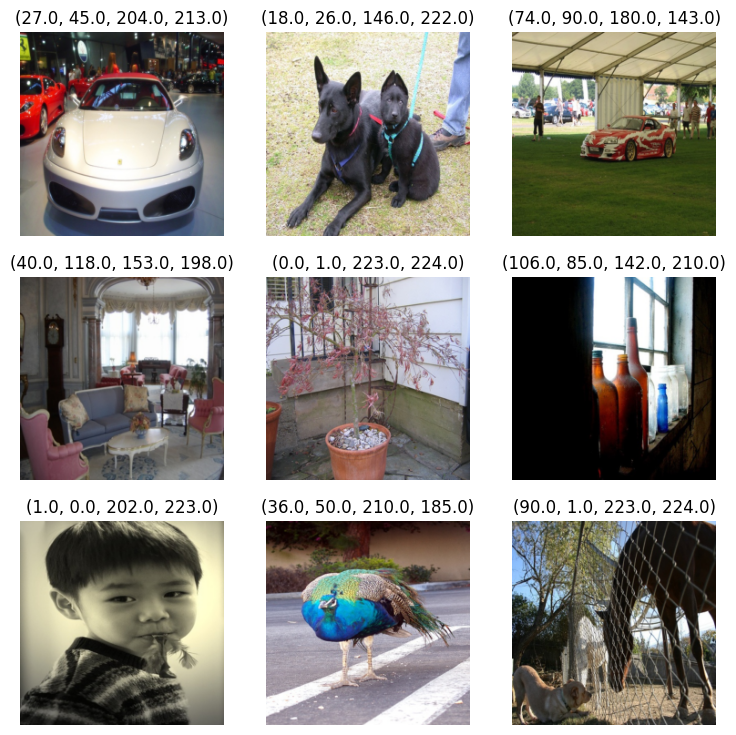

In [22]:
dls.show_batch()

Our bounding box labels are just four numbers as far as FAI is concerned.  Since this a little less than satisfying, let's write a bit of code to better visualize the bounding boxes.

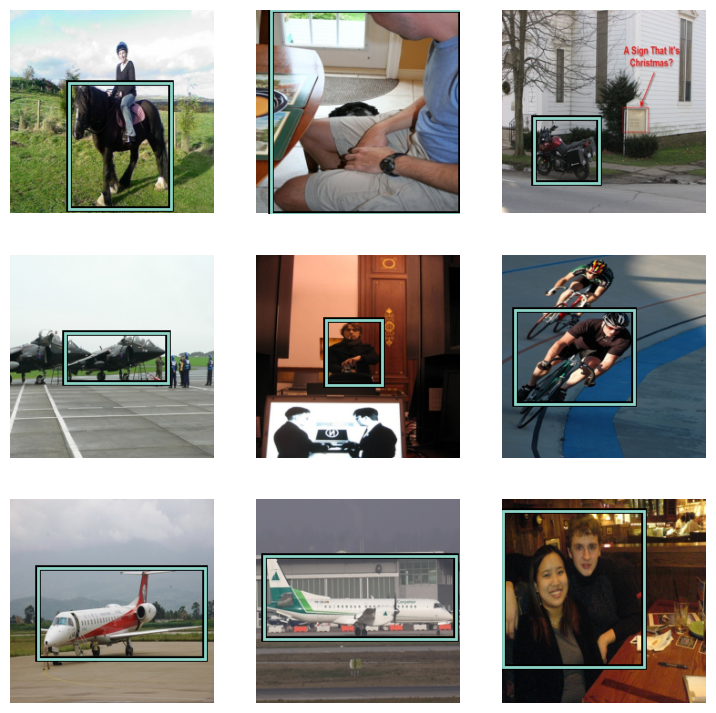

In [23]:
def bb_hw(a): return np.array([a[0],a[1],a[2]-a[0]+1,a[3]-a[1]+1])

def show_batch(dls):
    b = dls.one_batch()

    axs = subplots(3,3)[1].flat
    for img,box,ax in zip(b[0][:9],b[1][:9],axs):
        show_img(img,ax=ax)
        draw_rect(ax,bb_hw(box.tolist()),color=colr_list[0])
show_batch(dls)

Let's use the vision_learner API again to create a model for predicting bounding boxes.

In [24]:
learn = vision_learner(dls,resnet34,loss_func=L1LossFlat())

Let's look at the head of the model that the vision_learner API created for us this time.

In [25]:
# Let's look at the head that was constructed for us.
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

*Note that the out_features of the last layer has the right number of activations (four) that we need for our bounding box prediction.*

Now we just need to make sure that we have an appropriate loss function.  The default loss function for regression predictions is mean-squared error (MSELoss).  But MSELoss heavily penalizes differences between the predictions and the targets.  A better loss function for this scenario is L1Loss, which is the absolute value of the difference between predictions and targets.

In [26]:
learn.loss_func

FlattenedLoss of L1Loss()

Let's find a reasonble learning rate.

SuggestedLRs(valley=0.03981071710586548)

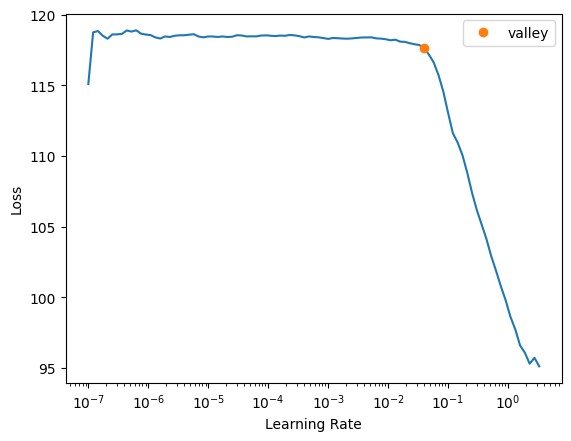

In [27]:
lrs = learn.lr_find()
lrs

### Train Our Model
We'll fit the model to our training data using the selected loss function.  Here we're using fine_tune method since we are using the resnet34 pretrained weights.

In [28]:
learn.fine_tune(30,base_lr=lrs.valley)

epoch,train_loss,valid_loss,time
0,116.243683,105.993599,00:06


epoch,train_loss,valid_loss,time
0,98.267700,84.453842,00:07
1,90.950829,77.133057,00:07
2,81.379288,58.756008,00:07
3,68.010071,31.680017,00:07
4,54.246552,30.773258,00:07
5,44.682934,27.403236,00:07
6,38.025078,26.965055,00:07
7,33.165363,27.332207,00:07
8,29.238724,24.542305,00:07
9,25.977249,24.442560,00:07


Now that we've trained the model, let's take a look at some predictions to see how it's doing.

In [29]:
def show_preds(learner,valid=False):
    learn.model.eval()
    dl = learn.dls[1 if valid else 0].new(shuffle=True)
    imgs,boxes = dl.one_batch()
    preds = learner.model(imgs).tolist()

    fig,axs = subplots(9,2)
    for img,box,pred,ax in zip(imgs,boxes,preds,axs):
        img = (img-img.min())/(img.max()-img.min())
        show_img(img,ax=ax[0])
        draw_rect(ax[0],bb_hw(box.tolist()),color=colr_list[0])
        show_img(img,ax=ax[1])
        draw_rect(ax[1],bb_hw(pred),color=colr_list[0])
    fig.tight_layout()
    axs[0][0].set_title('label')
    axs[0][1].set_title('prediction')
    plt.show()

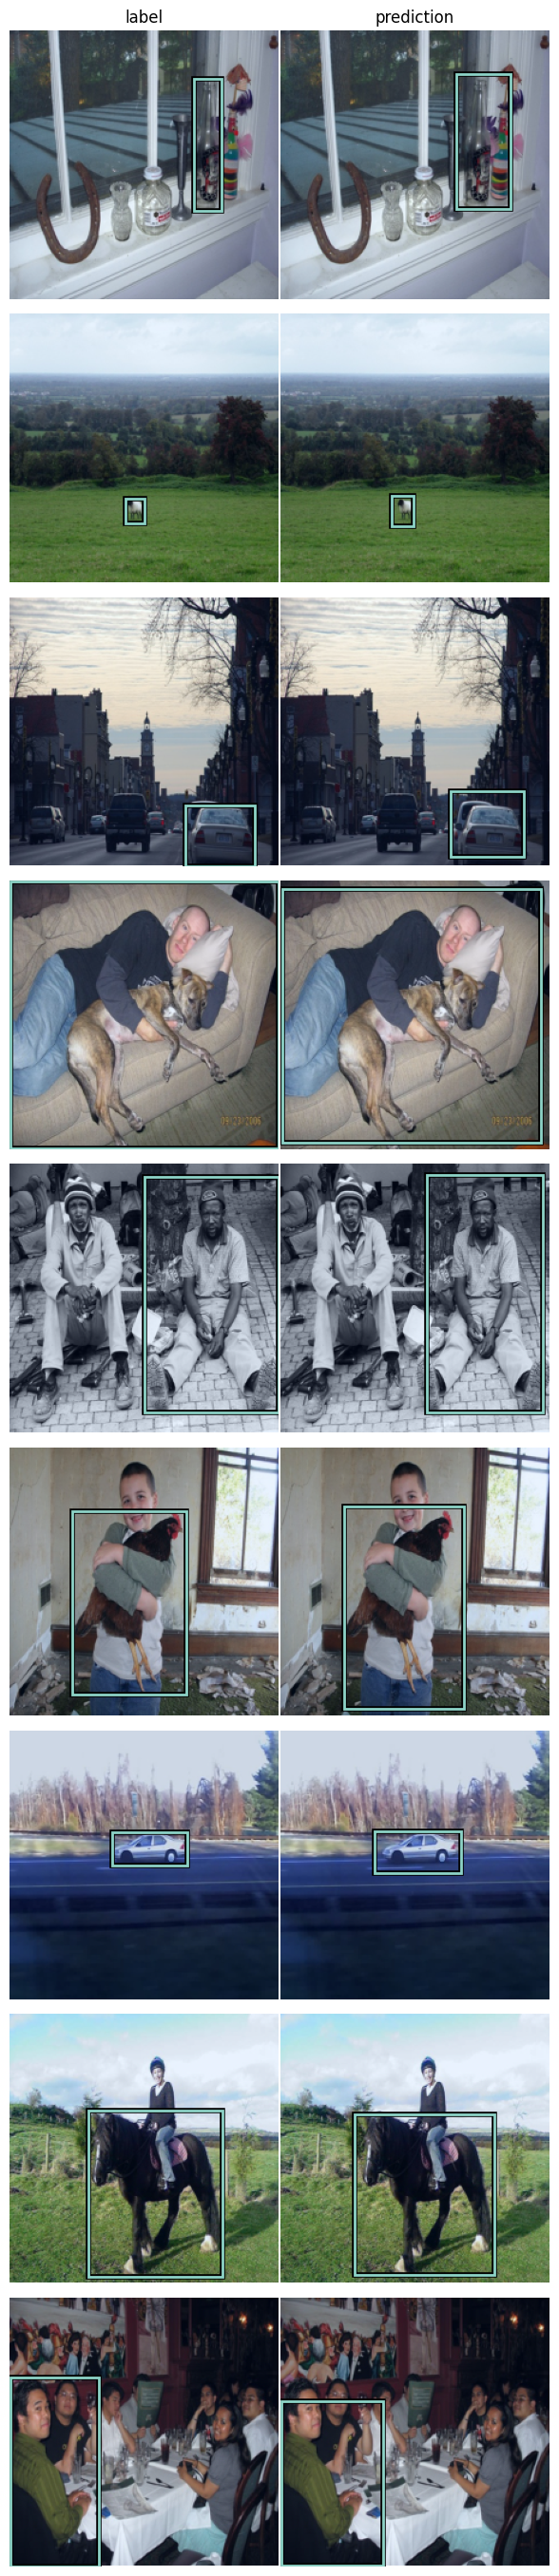

In [30]:
show_preds(learn)

The ground truth bounding boxes that came with our training dataset are shown in the left-hand column.  This looks pretty good but there still is a bit of confusion when there are multiple objects of the same class, the model seems to "split" the difference between multiple objects.  Let's continue to iterate and we'll continue to make improvements as we move to multiple object detection in an upcoming article.

## Summary
In this article, we dug a little deeper into Object Detection by writing a model that can predict just the bounding box for the largest object within an image. 

In the next installment, we'll pull things together a bit and extend our model so that it can predict both the bounding box and the class label of the largest object using a compound loss function.  

We still a have a several more articles ahead of us.  If you're enjoying it so far, please **like and retweet** my content on twitter, [@johnrobinsn](https://twitter.com/johnrobinsn)